<a href="https://colab.research.google.com/github/marcelocostamagna/diplo2019/blob/master/TP2/Diplo_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Clusters con K-means

Cohorte Omega <br>
Grupo 9 - Marcelo Costamagna, Angelina Garnica <br>
5/6/2019


## Ciencia de Datos aplicada en la Industria Retail

In [4]:
if (!require("RCurl")) install.packages("RCurl")
if (!require("GGally")) install.packages("GGally")
if (!require("gridExtra")) install.packages("gridExtra")
if (!require("tidyverse")) install.packages("tidyverse")

Loading required package: RCurl
Loading required package: bitops

Attaching package: ‘RCurl’

The following object is masked from ‘package:tidyr’:

    complete

Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



Cargamos los datos de las tablas correspondientes:

In [0]:
x <- getURL("https://raw.githubusercontent.com/maxiarmesto/retail_data_analytics/master/sales.csv")
sales <- read.csv(text = x)

x <- getURL("https://raw.githubusercontent.com/maxiarmesto/retail_data_analytics/master/stores.csv")
stores <- read.csv(text = x)

x <- getURL("https://raw.githubusercontent.com/maxiarmesto/retail_data_analytics/master/features.csv")
features <- read.csv(text = x)

A los fines de realizar un análisis de cluster para las 45 tiendas anónimas localizadas en diferentes departamentos, se buscará extraer de la base de ventas todas aquellas variables que permitan caracterizar a las tiendas.

Al analizar la base de ventas se observa la presencia de 8.452 ids duplicados que son excluídos de la base.


In [0]:
dup <- sales %>%
  group_by(Sale.Id) %>%
  mutate(q = n()) %>%
  filter(q > 1)

sales <- sales %>%
  distinct(Sale.Id, .keep_all = T)

#Cantidad de semanas de información por store y departamento 

T1 <- sales %>%
  group_by(Store, Dept) %>%
  summarise(q = n())

#Cantdad de departamentos, fecha min y max

sales$Date1 <- as.Date(as.character(sales$Date), format = "%d/%m/%Y")

T2 <- sales %>%
  group_by(Store) %>%
  summarise(dptos = n_distinct(Dept),
            sem = n(),
            fi = min(Date1),
            ff = max(Date1),
            total_ventas = sum(Weekly_Sales, na.rm = T),
            ventas_prom_sem = round(total_ventas/sem, 0))

Posteriormente se agrupan las variables de la base de ventas (sales) de la siguintte manera: <br>
dptos: Número de departamentos distintos por tienda <br>
sem: Cantidad de semanas para las que hay información en la base de ventas <br>
fi: fecha del primer registro de la base <br>
ff: fecha de la última semana de la base <br>
total_ventas: sumatoria de las ventas de todas las semanas <br>
ventas_prom_sem:promedio de ventas por semana <br>

Esta información se agregó a la base stores. Adicionalmente se encontraron 6 casos con valores faltantes en la variale Size (tamaño) los que fueron imputados teniendo en cuenta la media por tipo de tienda.

In [0]:
stores <- merge(stores, T2, by = "Store", all.x = T)

##Se verifican 6 casos sin tamaño => se imputa por la media del tipo

size <- stores %>%
  group_by(Type) %>%
  summarise(prom = round(mean(Size, na.rm = T), 0))

stores$Size1 <- ifelse(stores$Type == "A" & is.na(stores$Size) == T, as.numeric(size[1,2]),
                       ifelse(stores$Type == "B" & is.na(stores$Size) == T, as.numeric(size[2,2]),
                              ifelse(stores$Type == "C" & is.na(stores$Size) == T, as.numeric(size[3,2]),
                                     stores$Size)))



##Clusters
A los fines de obtener la mejor agrupación se fueron realizando diferentes pruebas. En primer lugar se estandarizaron las variables para evitar el efecto escala; luego se buscó definir mediante el gráfico Elbow, el número de clúster más adecuado.<br>
**Gráfico N°1**


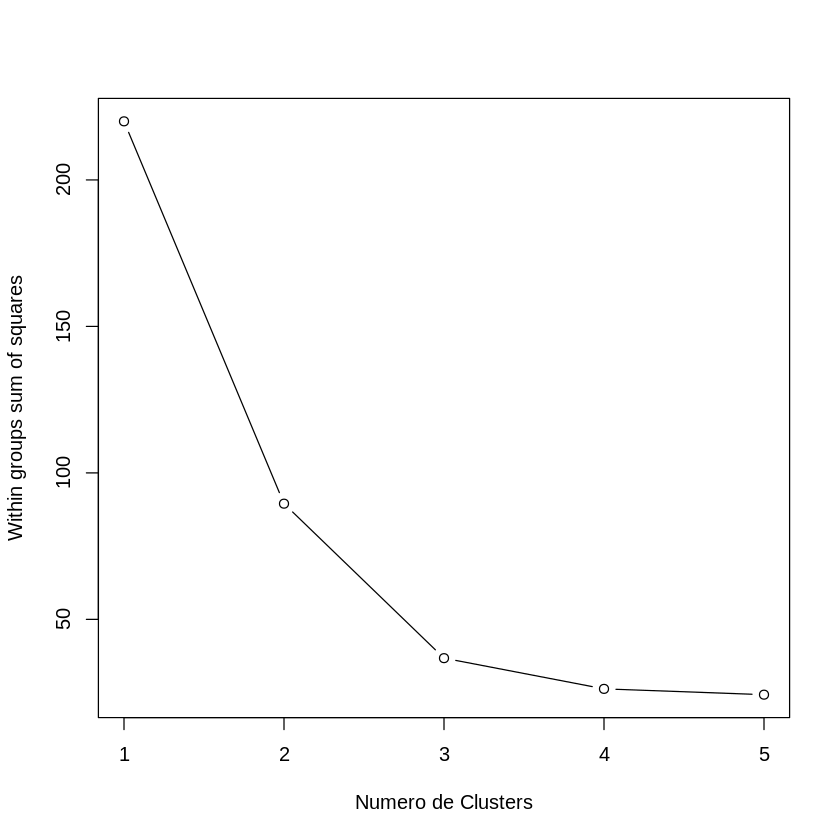

In [8]:
#Estandarizacion
stores.st <- scale(stores[, c(5,6,9:11)])

#NUMERO DE CLUSTER
#stores.st <- scale(stores[, c(9:11)])

wssplot <- function(data, nc=10, seed=20){
  wss <- (nrow(data)-1)*sum(apply(data,2,var))
  for (i in 2:nc){
    set.seed(seed)
    wss[i] <- sum(kmeans(data, centers=i)$withinss)}
  plot(1:nc, wss, type="b", xlab="Numero de Clusters",
       ylab="Within groups sum of squares")}

wssplot(stores.st, nc=5) 

Se consider adecuado el uso de tres Clusters.

## Cluster 1
Se consideran las variables tamaño, ventas totales, ventas por semana, cantidad de semanas con información y cantidad de departamentos.

In [9]:
Cluster_1 <- kmeans(stores.st, 3, nstart = 20)

Cluster_1$cluster <- as.factor(Cluster_1$cluster)
stores.st <- as.data.frame(stores.st)

c1_1 <- ggplot(stores.st, aes(ventas_prom_sem, dptos, color = Cluster_1$cluster)) + 
  geom_point()

c1_2 <- ggplot(stores.st, aes(ventas_prom_sem, sem, color = Cluster_1$cluster)) + 
  geom_point()

c1_3 <- ggplot(stores.st, aes(ventas_prom_sem, total_ventas, color = Cluster_1$cluster)) + 
  geom_point()

c1_4 <- ggplot(stores.st, aes(ventas_prom_sem, Size1, color = Cluster_1$cluster)) + 
  geom_point()

c1_5 <- ggplot(stores.st, aes(total_ventas, dptos, color = Cluster_1$cluster)) + 
  geom_point()

c1_6 <- ggplot(stores.st, aes(total_ventas, sem, color = Cluster_1$cluster)) + 
  geom_point()

c1_7 <- ggplot(stores.st, aes(total_ventas, Size1, color = Cluster_1$cluster)) + 
  geom_point()

c1_8 <- ggplot(stores.st, aes(dptos, sem, color = Cluster_1$cluster)) + 
  geom_point()

c1_9 <- ggplot(stores.st, aes(dptos, Size1, color = Cluster_1$cluster)) + 
  geom_point()

c1_10 <- ggplot(stores.st, aes(Size1, sem, color = Cluster_1$cluster)) + 
  geom_point()

Cluster_1


K-means clustering with 3 clusters of sizes 8, 18, 19

Cluster means:
       dptos        sem total_ventas ventas_prom_sem      Size1
1 -2.0376002 -2.0205089   -1.1220318      -0.9224774 -1.4223099
2  0.5855399  0.6637257    1.0422308       1.0357591  0.9266945
3  0.3032149  0.2219478   -0.5149421      -0.5928340 -0.2790537

Clustering vector:
 [1] 2 2 3 2 3 2 3 3 3 2 2 3 2 2 3 3 3 3 2 2 3 3 2 2 3 3 2 2 3 1 2 2 1 3 3 1 1 1
[39] 2 3 2 1 1 1 3
Levels: 1 2 3

Within cluster sum of squares by cluster:
[1]  2.319774 16.493515 17.949898
 (between_SS / total_SS =  83.3 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

Se realiza una comparación con la variable "Tipo" de la base de tiendas para analizar si la misma tiene alguna relación con las variables definidas para el modelo.

In [10]:
table(Cluster_1$cluster, stores$Type)

   
     A  B  C
  1  2  0  6
  2 16  2  0
  3  4 15  0

**Gráfico N°2**

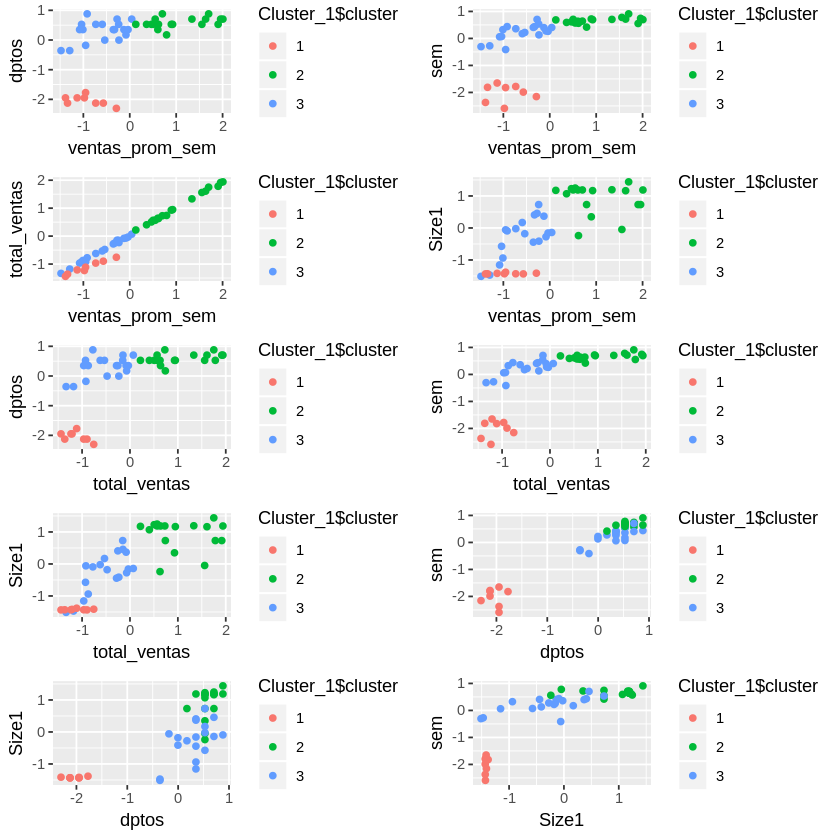

In [11]:
grid.arrange(c1_1, c1_2, c1_3, c1_4, c1_5, c1_6, c1_7, c1_8, c1_9, c1_10, ncol=2, nrow =5)

## Cluster 2
Se eliminan las variables cantidad de semanas (sem) y cantidad de departamentos (dptos). k=3 .

In [0]:
stores.st <- stores.st[, c(3:5)]

set.seed(20)
Cluster_2 <- kmeans(stores.st, 3, nstart = 20)

Cluster_2$cluster <- as.factor(Cluster_2$cluster)

stores.st <- as.data.frame(stores.st)

c2_1 <- ggplot(stores.st, aes(ventas_prom_sem, total_ventas, color = Cluster_2$cluster)) + 
  geom_point()

c2_2 <- ggplot(stores.st, aes(ventas_prom_sem, Size1, color = Cluster_2$cluster)) + 
  geom_point()

c2_3 <- ggplot(stores.st, aes(Size1, total_ventas, color = Cluster_2$cluster)) + 
  geom_point()


In [13]:
Cluster_2
table(Cluster_2$cluster, stores$Type)

K-means clustering with 3 clusters of sizes 13, 16, 16

Cluster means:
  total_ventas ventas_prom_sem       Size1
1   -1.0964386      -1.0217049 -1.30997156
2   -0.2287717      -0.2882764  0.08029302
3    1.1196281       1.1184116  0.98405888

Clustering vector:
 [1] 3 3 1 3 1 3 1 2 2 3 3 2 3 3 2 1 2 2 3 3 2 2 2 3 2 2 3 3 1 1 3 2 1 2 2 1 1 1
[39] 3 2 3 1 1 1 2
Levels: 1 2 3

Within cluster sum of squares by cluster:
[1]  2.791796  7.587828 12.278560
 (between_SS / total_SS =  82.8 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

   
     A  B  C
  1  2  5  6
  2  5 11  0
  3 15  1  0

**Gráfico N° 3**

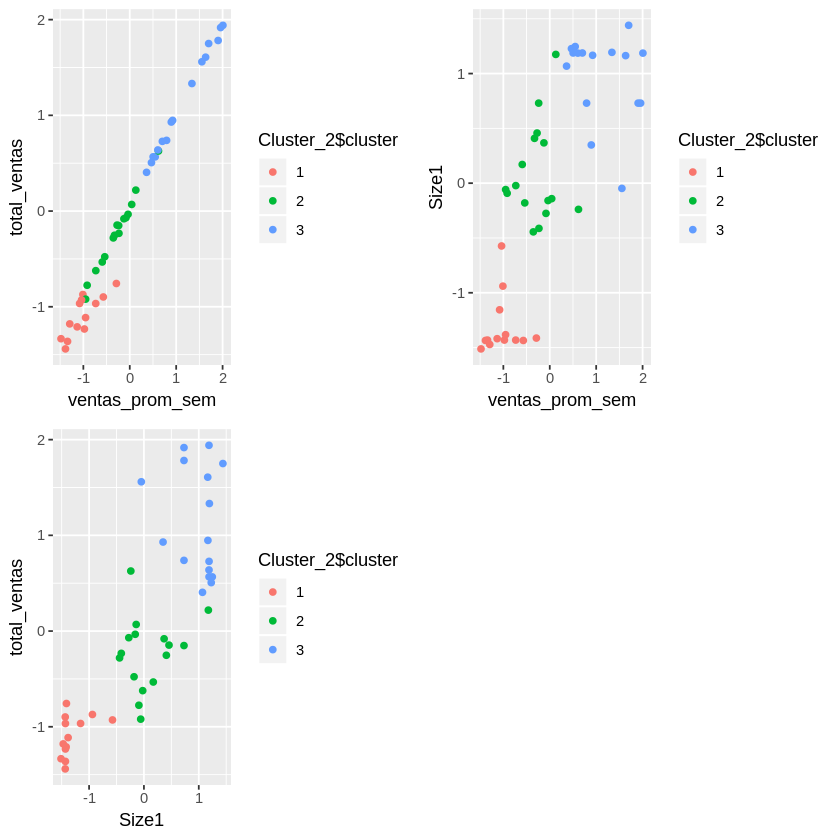

In [14]:
grid.arrange(c2_1, c2_2, c2_3, ncol=2, nrow =2)

Tenindo en cuenta los dos modelos anteriores, se opta por el segundo, dado que presenta un menor valor de la suma de cuadrados dentro de los grupos (withinss) y al tener menos variables se facilita su inerpretación. 

Se observa que los grupos (cúmulos) identificados en el modelo están asociados al volumen de ventas y a la variable definida como tamaño. El grupo 1 representa las tiendas de menor tamaño y menores ventas, el grupo 3 es el grupo intermedio y el grupo 2 el de mayores ventas y tamaño. No se observa relación directa con la variable tipo de tienda (Type).

Por último se presenta el modelo no normalizado a los fines de observar la influencia de la normalizacion de los datos en los resultados del clustering.


In [15]:
set.seed(20)
Cluster_3 <- kmeans(stores[, c(9:11)], 3, nstart = 20)

Cluster_3

K-means clustering with 3 clusters of sizes 18, 18, 9

Cluster means:
  total_ventas ventas_prom_sem     Size1
1     73368219         8811.00  69652.89
2    166284259        16645.67 161831.28
3    269274930        26276.67 184508.33

Clustering vector:
 [1] 3 3 1 3 1 3 1 2 1 3 2 2 3 3 1 1 2 2 2 3 1 2 2 2 1 2 3 2 1 1 2 2 1 2 2 1 1 1
[39] 2 2 2 1 1 1 1

Within cluster sum of squares by cluster:
[1] 8.269108e+15 1.488244e+16 7.183981e+15
 (between_SS / total_SS =  88.7 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

Si bien los resultados indican que los clusters del modelo no normalizado explican un porcentje mayor de la variabilidad en los datos que el modelo anterior (88.7% y 82.8% respectivamente), la suma de cuadrados dentro de los grupos (withinss) es mucho considerablemente menor en el modelo 2 (modelo estandarizado con tres variables).

In [16]:
Cluster_1$tot.withinss
Cluster_2$tot.withinss
Cluster_3$tot.withinss

[1] 36.76319

[1] 22.65818

[1] 3.033553e+16